In [1]:
# Reed Whitcraft
# Mod 03 Project
# Friday, May 10, 2019

# NBA Game Outcome Classifier

### **Underlying Question**: 
Can we accurately classify NBA games as won/lost using statistics through the first three quarters? 

### **Data Background**: 
Each team in the NBA plays 82 games a year, and between all NBA teams, there are a total of 1,230 games per year (ignoring lockout).  So, to get enough data, we'll be pulling games from multiple seasons (7).  The focus of our classifier will be on predicting whether the **home team** wins using only data from the first three quarters.

### **The Dataset**: 
All NBA regular season games from the last seven seasons (2012 - 2019), sourced from [stats.nba](https://stats.nba.com) JSON endpoint.  Each game instance returned from the JSON endpoint has extraneous statistics and attributes, so when loading the JSON and creating our dataset, we hand pick only a couple of traditional metrics.


### ASIDE: Skipping Data Preprocessing & Loading From Processed CSV

To skip having to wait for the database loading & pre-processing:

In section `Data Preprocessing`, import necessary libraries (1.0.1)

SKIP TO `Dataset CSV (Pre-Processed)` and run those two cells.

# Data Preprocessing

#### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import json

### Data Handling Process

Since the NBA returns traditional and advanced statistics from two different endpoints, we only use the traditional statistics endpoint, and calculate the advanced metrics from this.  Additionally, the nba.stats.com API returns 1st Half & individual quarters for an individual season from different endpoints, and returns two rows for each NBA game, one for the home team and one for the away team.  

Ultimately, I would like to have single dataframe that:

- Has the "End of Third Quarter" Statistics (from two different endpoints)
- Has Team & Opponent Statistics (from two rows in each endpoint)

To get here, I'll have to:

- **Import Half Time + 3rd Quarter** stats for a single season

- **Drop extra columns** that nba.stats.com returns (Season Ranks, Team Names, Game Times, etc.)

- **Rename columns** in each dataframe to reflect which stat we're working with ("HALF_", "3Q_")

- **Combine Half Time + 3rd Quarter** dataframes into a single dataframe, on their matching GAME_ID and TEAM_ID.

- **Add "HALF_" + "3Q_"** stat columns to get "End of 3rd Quarter" stats

- **Drop "HALF_" + "3Q_"** stat columns

- **Recalculate statistics** (FG%, FG3%, FT%)

- **Set "HOME" column** (binary) for rows (Matchup field contains 'vs.' if home)

- **Sort dataframe** by GAME_ID, since there are two rows per game (home and away)

- **Iterate dataframe** and add away team's stats to home team rows as "OPP_[STAT]"

- **Drop away team rows** (since all the statistics are now in the home team rows)

- **Calculate four factor** (advanced NBA metrics) statistics for home and opponent stats

- **Drop columns** used in feature engineering four factor metrics

Since I'll be doing this for multiple seasons (7), I'll walk through the first season, then bundle the remaining seasons. 

### Import nba.py (methods moved for workflow)

Originally, I started the project only using games from the 2018-2019 season, but the initial model performance was subpar, so I decided I'd try to feed the model more data in the hopes of improving its performance.  As a result of this change mid project, I moved the data wrangling process into a python file so that I could loop through JSON files for each season at once.  Below, I'll go through the first season step-by-step, and then do the remaining seasons altogether.  At the end of the data preprocessing, I save the combined dataframe for the last seven seasons as a CSV so that, when running from the beginning, one does not have to wait, but can start with the cleaned final version of the dataset.

In [107]:
###
### methods to import & parse JSON, add/drop columns, calculate stats, merge dataframes, etc
###

from nba import *

## 2012-2013 NBA Box Scores Data Handling Walkthrough

#### Extract Headers/Columns

In [3]:
df_half, df_3q = load_json('data/HALF/2012-2013-box-score.json', 'data/3Q/2012-2013-box-score.json')

In [4]:
df_half.head(3)

,SEASON_YEAR,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK
0,2012-13,1610612751,BKN,Brooklyn Nets,0021201217,2013-04-17T00:00:00,BKN vs. DET,W,24.0,24,...,1326,181,1729,248,1706,1303,1489,655,186,274
1,2012-13,1610612754,IND,Indiana Pacers,0021201221,2013-04-17T00:00:00,IND vs. PHI,L,24.0,15,...,2098,2335,2000,1856,1706,1802,23,193,2320,2412
2,2012-13,1610612755,PHI,Philadelphia 76ers,0021201221,2013-04-17T00:00:00,PHI @ IND,W,24.0,27,...,358,1538,1379,248,325,238,2072,2381,224,37


#### Remove Seasonal/Non-Statistical Columns

In [5]:
df_half = remove_extra_columns(df_half) # remove team name, season year, other non-statistical columns
df_3q = remove_extra_columns(df_3q) # remove team name, season year, other non-statistical columns

In [6]:
df_half.head(3)

,TEAM_ID,GAME_ID,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,...,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS
0,1610612751,0021201217,BKN vs. DET,W,24.0,24,45,0.533,4,11,...,20,16,9.0,6,1,3,10,10,60,12.0
1,1610612754,0021201221,IND vs. PHI,L,24.0,15,37,0.405,1,10,...,16,6,10.0,2,1,4,4,12,37,-22.0
2,1610612755,0021201221,PHI @ IND,W,24.0,27,46,0.587,4,9,...,25,10,8.0,6,4,1,12,4,59,22.0


#### Prefix Columns with "HALF_" or "3Q_"

Because a single game is served from two different endpoints, I relabel the half time dataset with "HALF_" and the third quarter with "3Q_" so that I can keep both while merging rows and calculating totals.

In [7]:
df_half = rename_stats_with_period(df_half, "HALF_")
df_3q = rename_stats_with_period(df_3q, "3Q_")

In [8]:
print(df_half.columns)

Index(['TEAM_ID', 'GAME_ID', 'MATCHUP', 'WL', 'HALF_MIN', 'HALF_FGM',
       'HALF_FGA', 'HALF_FG_PCT', 'HALF_FG3M', 'HALF_FG3A', 'HALF_FG3_PCT',
       'HALF_FTM', 'HALF_FTA', 'HALF_FT_PCT', 'HALF_OREB', 'HALF_DREB',
       'HALF_REB', 'HALF_AST', 'HALF_TOV', 'HALF_STL', 'HALF_BLK', 'HALF_BLKA',
       'HALF_PF', 'HALF_PFD', 'HALF_PTS', 'HALF_PLUS_MINUS'],
      dtype='object')


#### Combine HALF & 3Q Dataframes

In [9]:
df_combined = merge_dataframes(df_half, df_3q) # merge 3Q & HALF dataframes

In [10]:
df_combined.head()

,TEAM_ID,GAME_ID,MATCHUP,WL,HALF_MIN,HALF_FGM,HALF_FGA,HALF_FG_PCT,HALF_FG3M,HALF_FG3A,...,3Q_REB,3Q_AST,3Q_TOV,3Q_STL,3Q_BLK,3Q_BLKA,3Q_PF,3Q_PFD,3Q_PTS,3Q_PLUS_MINUS
0,1610612751,0021201217,BKN vs. DET,W,24.0,24,45,0.533,4,11,...,11,6,9.0,4,0,1,4,10,23,5.0
1,1610612754,0021201221,IND vs. PHI,L,24.0,15,37,0.405,1,10,...,14,7,4.0,2,1,1,5,6,31,5.0
2,1610612755,0021201221,PHI @ IND,W,24.0,27,46,0.587,4,9,...,6,3,3.0,2,1,1,6,5,26,-5.0
3,1610612750,0021201225,MIN @ SAS,W,24.0,21,47,0.447,7,16,...,8,7,2.0,5,1,0,1,5,24,9.0
4,1610612744,0021201230,GSW @ POR,W,24.0,21,53,0.396,4,10,...,9,5,3.0,0,3,2,5,1,16,-11.0


#### Sum HALF_ & 3Q_ Columns to get End of Third Quarter Stats

In [11]:
df_combined = combine_3q_half_stats(df_combined) # add column that is sum of "HALF_[STAT]" + "3Q_[STAT]"
df_combined.columns

Index(['TEAM_ID', 'GAME_ID', 'MATCHUP', 'WL', 'HALF_MIN', 'HALF_FGM',
       'HALF_FGA', 'HALF_FG_PCT', 'HALF_FG3M', 'HALF_FG3A', 'HALF_FG3_PCT',
       'HALF_FTM', 'HALF_FTA', 'HALF_FT_PCT', 'HALF_OREB', 'HALF_DREB',
       'HALF_REB', 'HALF_AST', 'HALF_TOV', 'HALF_STL', 'HALF_BLK', 'HALF_BLKA',
       'HALF_PF', 'HALF_PFD', 'HALF_PTS', 'HALF_PLUS_MINUS', '3Q_MIN',
       '3Q_FGM', '3Q_FGA', '3Q_FG_PCT', '3Q_FG3M', '3Q_FG3A', '3Q_FG3_PCT',
       '3Q_FTM', '3Q_FTA', '3Q_FT_PCT', '3Q_OREB', '3Q_DREB', '3Q_REB',
       '3Q_AST', '3Q_TOV', '3Q_STL', '3Q_BLK', '3Q_BLKA', '3Q_PF', '3Q_PFD',
       '3Q_PTS', '3Q_PLUS_MINUS', 'MIN', 'FGM', 'FGA', 'FG3M', 'FG3A', 'FTM',
       'FTA', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK', 'BLKA', 'PF',
       'PFD', 'PTS', 'PLUS_MINUS'],
      dtype='object')

#### Recalculate Combined Statistics (FG%, FT%)

In [12]:
df_combined = recalculate_combined_stats(df_combined) # calculate FG %, FT % for new, combined totals (3Q + HALF)

#### Add Home Column (Matchup str contains 'vs.')

In [13]:
df_combined = set_home_column(df_combined)

#### Sort DataFrame by GAME (to pair home & away teams)

In [14]:
df_combined = sort_df_by_game(df_combined)
df_combined.head(3)

,TEAM_ID,GAME_ID,MATCHUP,WL,HALF_MIN,HALF_FGM,HALF_FGA,HALF_FG_PCT,HALF_FG3M,HALF_FG3A,...,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,FG_PCT,FG3_PCT,FT_PCT,HOME
2456,1610612739,0021200001,CLE vs. WAS,W,24.0,20,41,0.488,3,8,...,3,9,14,13,74,12.0,0.460317,0.428571,0.666667,1
2452,1610612764,0021200001,WAS @ CLE,L,24.0,14,43,0.326,5,13,...,9,3,13,14,62,-12.0,0.375000,0.318182,0.538462,0
2454,1610612748,0021200002,MIA vs. BOS,W,24.0,21,41,0.512,5,9,...,4,1,14,16,93,17.0,0.566667,0.538462,0.818182,1


#### Iterate DataFrame & Add Away Team Stats to Home Team Rows as "OPP_[STAT]"

In [15]:
df_combined = add_opponent_stats_to_df(df_combined)
df_combined.head(3)

,TEAM_ID,GAME_ID,MATCHUP,WL,HALF_MIN,HALF_FGM,HALF_FGA,HALF_FG_PCT,HALF_FG3M,HALF_FG3A,...,OPP_REB,OPP_AST,OPP_TOV,OPP_STL,OPP_BLK,OPP_BLKA,OPP_PF,OPP_PFD,OPP_PTS,OPP_PLUS_MINUS
2456,1610612739,0021200001,CLE vs. WAS,W,24.0,20,41,0.488,3,8,...,27.0,22.0,11.0,6.0,9.0,3.0,13.0,14.0,62.0,-12.0
2452,1610612764,0021200001,WAS @ CLE,L,24.0,14,43,0.326,5,13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2454,1610612748,0021200002,MIA vs. BOS,W,24.0,21,41,0.512,5,9,...,30.0,16.0,14.0,4.0,1.0,4.0,16.0,14.0,76.0,-17.0


#### Drop Away Team Rows (all statistics encapsulated in home team rows)

In [16]:
print("Original Row Count: ", len(df_combined))
df_combined = drop_unused_rows(df_combined)
print("Rows w/o Away Count: ", len(df_combined))

Original Row Count:  2458
Rows w/o Away Count:  1229


#### Feature Engineer Four Factor Statistics

Below is a great article about advanced analytics in the NBA, and I will be using the four statistics described.

[Introduction to Four Factors: Score, Protect, Crash, and Attack](https://squared2020.com/2017/09/05/introduction-to-olivers-four-factors/)

The four factors are to **score efficiently, protect the basketball on offense, grab as many rebounds as possible, and get to the foul line as often as possible**.  Each of these factors are closely related to the termination of a possession for a team. 

Calculating:

    1. Effective FG%: (FGM + 0.5*FG3M)/FGA
    2. Turnover %: (FGA - OR + TO + 0.4*FTA)/TO
    3. Offensive Rebound %: OR/(OR + OPP_DREB)
    3b. Defensive Rebound %: DREB / (OPP FG Misses)
    4. Free Throw Rate: FTA/FGA
    

In [17]:
df_combined = calculate_four_factor_statistics(df_combined)
df_combined.head(3)

,TEAM_ID,GAME_ID,MATCHUP,WL,HALF_MIN,HALF_FGM,HALF_FGA,HALF_FG_PCT,HALF_FG3M,HALF_FG3A,...,OPP_PTS,OPP_PLUS_MINUS,EFG_PCT,TOV_PCT,OREB_PCT,FT_RATE,OPP_EFG_PCT,OPP_TOV_PCT,OPP_FT_RATE,DREB_PCT
2456,1610612739,0021200001,CLE vs. WAS,W,24.0,20,41,0.488,3,8,...,62.0,-12.0,0.507937,0.196970,0.533333,0.238095,0.429688,0.163690,0.203125,0.575000
2454,1610612748,0021200002,MIA vs. BOS,W,24.0,21,41,0.512,5,9,...,76.0,-17.0,0.625000,0.097493,0.148148,0.366667,0.500000,0.193370,0.368421,0.766667
2455,1610612747,0021200003,LAL vs. DAL,L,24.0,19,34,0.559,2,5,...,74.0,8.0,0.509091,0.138037,0.242424,0.418182,0.537879,0.126761,0.075758,0.696970


#### Drop HALF_ & 3Q_ columns

In [18]:
print("Original Column Count: ", len(df_combined.columns))
df_combined = drop_3q_half_columns(df_combined)
print("New Column Count: ", len(df_combined.columns))

Original Column Count:  98
New Column Count:  54


#### Drop columns used in feature engineering

In [19]:
print("Original Column Count: ", len(df_combined.columns))
df_combined = drop_columns_used_in_feature_engineering(df_combined)
print("Final Column Count: ", len(df_combined.columns))

Original Column Count:  54
Final Column Count:  15


#### Drop Matchup

In [20]:
df_combined.drop('MATCHUP', axis=1, inplace=True)

#### Final DataFrame

In [21]:
df_combined.head(3)

,WL,AST,BLK,PLUS_MINUS,OPP_AST,OPP_BLK,EFG_PCT,TOV_PCT,OREB_PCT,FT_RATE,OPP_EFG_PCT,OPP_TOV_PCT,OPP_FT_RATE,DREB_PCT
2456,W,18,3,12.0,22.0,9.0,0.507937,0.196970,0.533333,0.238095,0.429688,0.163690,0.203125,0.575000
2454,W,21,4,17.0,16.0,1.0,0.625000,0.097493,0.148148,0.366667,0.500000,0.193370,0.368421,0.766667
2455,L,18,3,-8.0,17.0,4.0,0.509091,0.138037,0.242424,0.418182,0.537879,0.126761,0.075758,0.696970


In [22]:
df_combined.describe()

,AST,BLK,PLUS_MINUS,OPP_AST,OPP_BLK,EFG_PCT,TOV_PCT,OREB_PCT,FT_RATE,OPP_EFG_PCT,OPP_TOV_PCT,OPP_FT_RATE,DREB_PCT
count,1229.000000,1229.000000,1229.000000,1229.000000,1229.00000,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000
mean,17.648495,4.049634,2.587469,16.563873,3.66965,0.509452,0.151120,0.266252,0.255593,0.494866,0.157335,0.245878,0.693275
std,4.035485,2.291461,12.282169,4.140866,2.22875,0.075111,0.042555,0.089433,0.104822,0.072328,0.044219,0.099735,0.096443
min,6.000000,0.000000,-34.000000,5.000000,0.00000,0.307692,0.013514,0.000000,0.029851,0.253968,0.038462,0.015152,0.289474
25%,15.000000,2.000000,-5.000000,14.000000,2.00000,0.456140,0.119681,0.200000,0.178571,0.447368,0.126984,0.173913,0.628571
50%,17.000000,4.000000,4.000000,16.000000,3.00000,0.508197,0.148810,0.264706,0.242857,0.492063,0.155807,0.237288,0.692308
75%,20.000000,5.000000,11.000000,19.000000,5.00000,0.558333,0.181058,0.323529,0.318182,0.541667,0.185644,0.305085,0.758621
max,33.000000,12.000000,45.000000,31.000000,14.00000,0.764706,0.297450,0.558824,0.800000,0.715385,0.293296,0.632653,1.047619


## 2013-2019 NBA Box Scores Data Handling

Below is exactly what we have done above for a single season, but for the remaining seasons.  I've named the JSON files so that I can readily iterate through them.

In [23]:
season_dfs = [df_combined]
seasons = ['2013-2014', '2014-2015', '2015-2016', '2016-2017', '2017-2018', '2018-2019']
for season in seasons:
    path_half = 'data/HALF/' + season + '-box-score.json'
    path_3q = 'data/3Q/' + season + '-box-score.json'
    df_half, df_3q = load_json(path_half, path_3q)
    
    df_half = remove_extra_columns(df_half) # remove team name, season year, other non-statistical columns
    df_half = rename_stats_with_period(df_half, "HALF_")

    df_3q = remove_extra_columns(df_3q) # remove team name, season year, other non-statistical columns
    df_3q = rename_stats_with_period(df_3q, "3Q_")

    df_combined = merge_dataframes(df_half, df_3q) # merge 3Q & HALF dataframes

    df_combined = combine_3q_half_stats(df_combined) # add column that is sum of "HALF_[STAT]" + "3Q_[STAT]"
    df_combined = recalculate_combined_stats(df_combined) # calculate FG %, FT % for new, combined totals (3Q + HALF)
    df_combined = set_home_column(df_combined)
    df_combined = sort_df_by_game(df_combined)
    df_combined = add_opponent_stats_to_df(df_combined)
    df_combined = drop_unused_rows(df_combined)
    df_combined = calculate_four_factor_statistics(df_combined)
    df_combined = drop_3q_half_columns(df_combined)
    df_combined = drop_columns_used_in_feature_engineering(df_combined)
    
    season_dfs.append(df_combined)

In [2]:
final_df = pd.concat(season_dfs)
final_df.drop('MATCHUP', axis=1, inplace=True)

NameError: name 'season_dfs' is not defined

In [25]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8608 entries, 2456 to 19
Data columns (total 14 columns):
AST            8608 non-null int64
BLK            8608 non-null int64
DREB_PCT       8608 non-null float64
EFG_PCT        8608 non-null float64
FT_RATE        8608 non-null float64
OPP_AST        8608 non-null float64
OPP_BLK        8608 non-null float64
OPP_EFG_PCT    8608 non-null float64
OPP_FT_RATE    8608 non-null float64
OPP_TOV_PCT    8608 non-null float64
OREB_PCT       8608 non-null float64
PLUS_MINUS     8608 non-null float64
TOV_PCT        8608 non-null float64
WL             8608 non-null object
dtypes: float64(11), int64(2), object(1)
memory usage: 1008.8+ KB


In [26]:
final_df.describe()

,AST,BLK,DREB_PCT,EFG_PCT,FT_RATE,OPP_AST,OPP_BLK,OPP_EFG_PCT,OPP_FT_RATE,OPP_TOV_PCT,OREB_PCT,PLUS_MINUS,TOV_PCT
count,8608.000000,8608.000000,8608.000000,8608.000000,8608.000000,8608.000000,8608.000000,8608.000000,8608.000000,8608.000000,8608.000000,8608.000000,8608.000000
mean,17.974442,3.811338,0.718615,0.518798,0.255982,17.030785,3.490590,0.505995,0.245946,0.148067,0.241861,2.224907,0.144998
std,4.348002,2.207479,0.097426,0.075635,0.103453,4.273186,2.081896,0.074105,0.101039,0.044152,0.085887,12.962434,0.043397
min,3.000000,0.000000,0.289474,0.210938,0.015873,3.000000,0.000000,0.220000,0.000000,0.012690,0.000000,-49.000000,0.013514
25%,15.000000,2.000000,0.655172,0.467742,0.181818,14.000000,2.000000,0.456140,0.173913,0.116883,0.181818,-6.000000,0.115607
50%,18.000000,4.000000,0.718750,0.516129,0.245902,17.000000,3.000000,0.507093,0.234375,0.146628,0.240000,2.000000,0.142857
75%,21.000000,5.000000,0.783784,0.569488,0.316667,20.000000,5.000000,0.555556,0.307692,0.177138,0.300000,11.000000,0.173333
max,37.000000,16.000000,1.142857,0.825397,0.933333,35.000000,14.000000,0.798387,0.818182,0.360111,0.560000,55.000000,0.337500


### Save Final DataFrame to CSV

No need to run the data aggregation and cleaning process multiple times, especially because iterating over the dataframe and matching home/away teams was computationally intensive and time consuming

In [48]:
export_csv = final_df.to_csv("2012-2019-dataframe.csv", index=False, header=True)

## Dataset CSV (Pre-Processed)

In [2]:
final_df = pd.read_csv('2012-2019-dataframe.csv', header=0)

In [3]:
final_df.describe()

,AST,BLK,DREB_PCT,EFG_PCT,FT_RATE,OPP_AST,OPP_BLK,OPP_EFG_PCT,OPP_FT_RATE,OPP_TOV_PCT,OREB_PCT,PLUS_MINUS,TOV_PCT
count,8608.000000,8608.000000,8608.000000,8608.000000,8608.000000,8608.000000,8608.000000,8608.000000,8608.000000,8608.000000,8608.000000,8608.000000,8608.000000
mean,17.974442,3.811338,0.718615,0.518798,0.255982,17.030785,3.490590,0.505995,0.245946,0.148067,0.241861,2.224907,0.144998
std,4.348002,2.207479,0.097426,0.075635,0.103453,4.273186,2.081896,0.074105,0.101039,0.044152,0.085887,12.962434,0.043397
min,3.000000,0.000000,0.289474,0.210938,0.015873,3.000000,0.000000,0.220000,0.000000,0.012690,0.000000,-49.000000,0.013514
25%,15.000000,2.000000,0.655172,0.467742,0.181818,14.000000,2.000000,0.456140,0.173913,0.116883,0.181818,-6.000000,0.115607
50%,18.000000,4.000000,0.718750,0.516129,0.245902,17.000000,3.000000,0.507093,0.234375,0.146628,0.240000,2.000000,0.142857
75%,21.000000,5.000000,0.783784,0.569488,0.316667,20.000000,5.000000,0.555556,0.307692,0.177138,0.300000,11.000000,0.173333
max,37.000000,16.000000,1.142857,0.825397,0.933333,35.000000,14.000000,0.798387,0.818182,0.360111,0.560000,55.000000,0.337500


### Final Features List (13)

    1. ASSISTS
    2. BLOCKS    
    3. EFFECTIVE FIELD GOAL %
    4. TURNOVER %
    5. OFFENSIVE REBOUND %
    6. FREE THROW RATE
    7. ASSISTS (OPPONENT)
    8. BLOCKS (OPPONENT)
    9. EFFECTIVE FIELD GOAL % (OPPONENT)
    10. TURNOVER % (OPPONENT)
    11. DEFENSIVE REBOUND % (OPPONENT)
    12. FREE THROW RATE (OPPONENT)
    13. PLUS MINUS

# EDA

### Import Libraries

In [4]:
from ipywidgets import interact, interactive # interactive plots
import ipywidgets as widgets 
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline

# plots' parameters with seaborn
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale = 1, rc = {"lines.linewidth": 2, 'font_family': [u'times']})

### Create Subsets for Visualization

In [5]:
eda_df = final_df.copy()

eda_df_w = eda_df.loc[eda_df["WL"] == "W"] # games that were won
eda_df_l = eda_df.loc[eda_df["WL"] == "L"] # games that were lost
print("Total Games: ", len(eda_df))
print("Total (Home) Wins: ", len(eda_df_w))
print("Total (Home) Losses: ", len(eda_df_l))
print("% (Home) Games Won: ", (len(eda_df_w)/len(eda_df)))

Total Games:  8608
Total (Home) Wins:  5056
Total (Home) Losses:  3552
% (Home) Games Won:  0.587360594795539


#### Set Features for Interactive Dropdown

In [6]:
all_columns = ['WL', 'AST', 'BLK', 'PLUS_MINUS', 'OPP_AST', 'OPP_BLK',
               'EFG_PCT', 'TOV_PCT', 'OREB_PCT', 'FT_RATE',
               'OPP_EFG_PCT', 'OPP_TOV_PCT', 'DREB_PCT', 'OPP_FT_RATE']

# without WL
feature_names = ['AST', 'BLK', 'PLUS_MINUS', 'OPP_AST', 'OPP_BLK',
                 'EFG_PCT', 'TOV_PCT', 'OREB_PCT', 'FT_RATE',
                 'OPP_EFG_PCT', 'OPP_TOV_PCT', 'DREB_PCT', 'OPP_FT_RATE']

### Distribution Plot of Team Statistics

In [7]:
@interact
def distribution_preview(feature = feature_names):
    sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [14, 5]})
    p = sns.distplot(eda_df[feature], label=feature, bins=20)
    plt.title("Distribution of {} (All Game Outcomes)".format(feature))
    p.legend()
    
    fig2 = plt.figure(figsize=(14,5))
    p = sns.distplot(eda_df_w[feature], label="{} in W".format(feature), bins=20)
    sns.distplot(eda_df_l[feature], label="{} in L".format(feature), bins=20)
    plt.title("Distribution of {} (W vs. L)".format(feature))
    p.legend()
    
    plt.show()

interactive(children=(Dropdown(description='feature', options=('AST', 'BLK', 'PLUS_MINUS', 'OPP_AST', 'OPP_BLK…

### Pairplot of Advanced Statistics

Looking at all the features at once will restrict what can be garnered from the visualizations, so I'll begin looking at the more traditional statistics (rebounds, assists, turnovers, steals, and blocks).

<Figure size 1152x576 with 0 Axes>

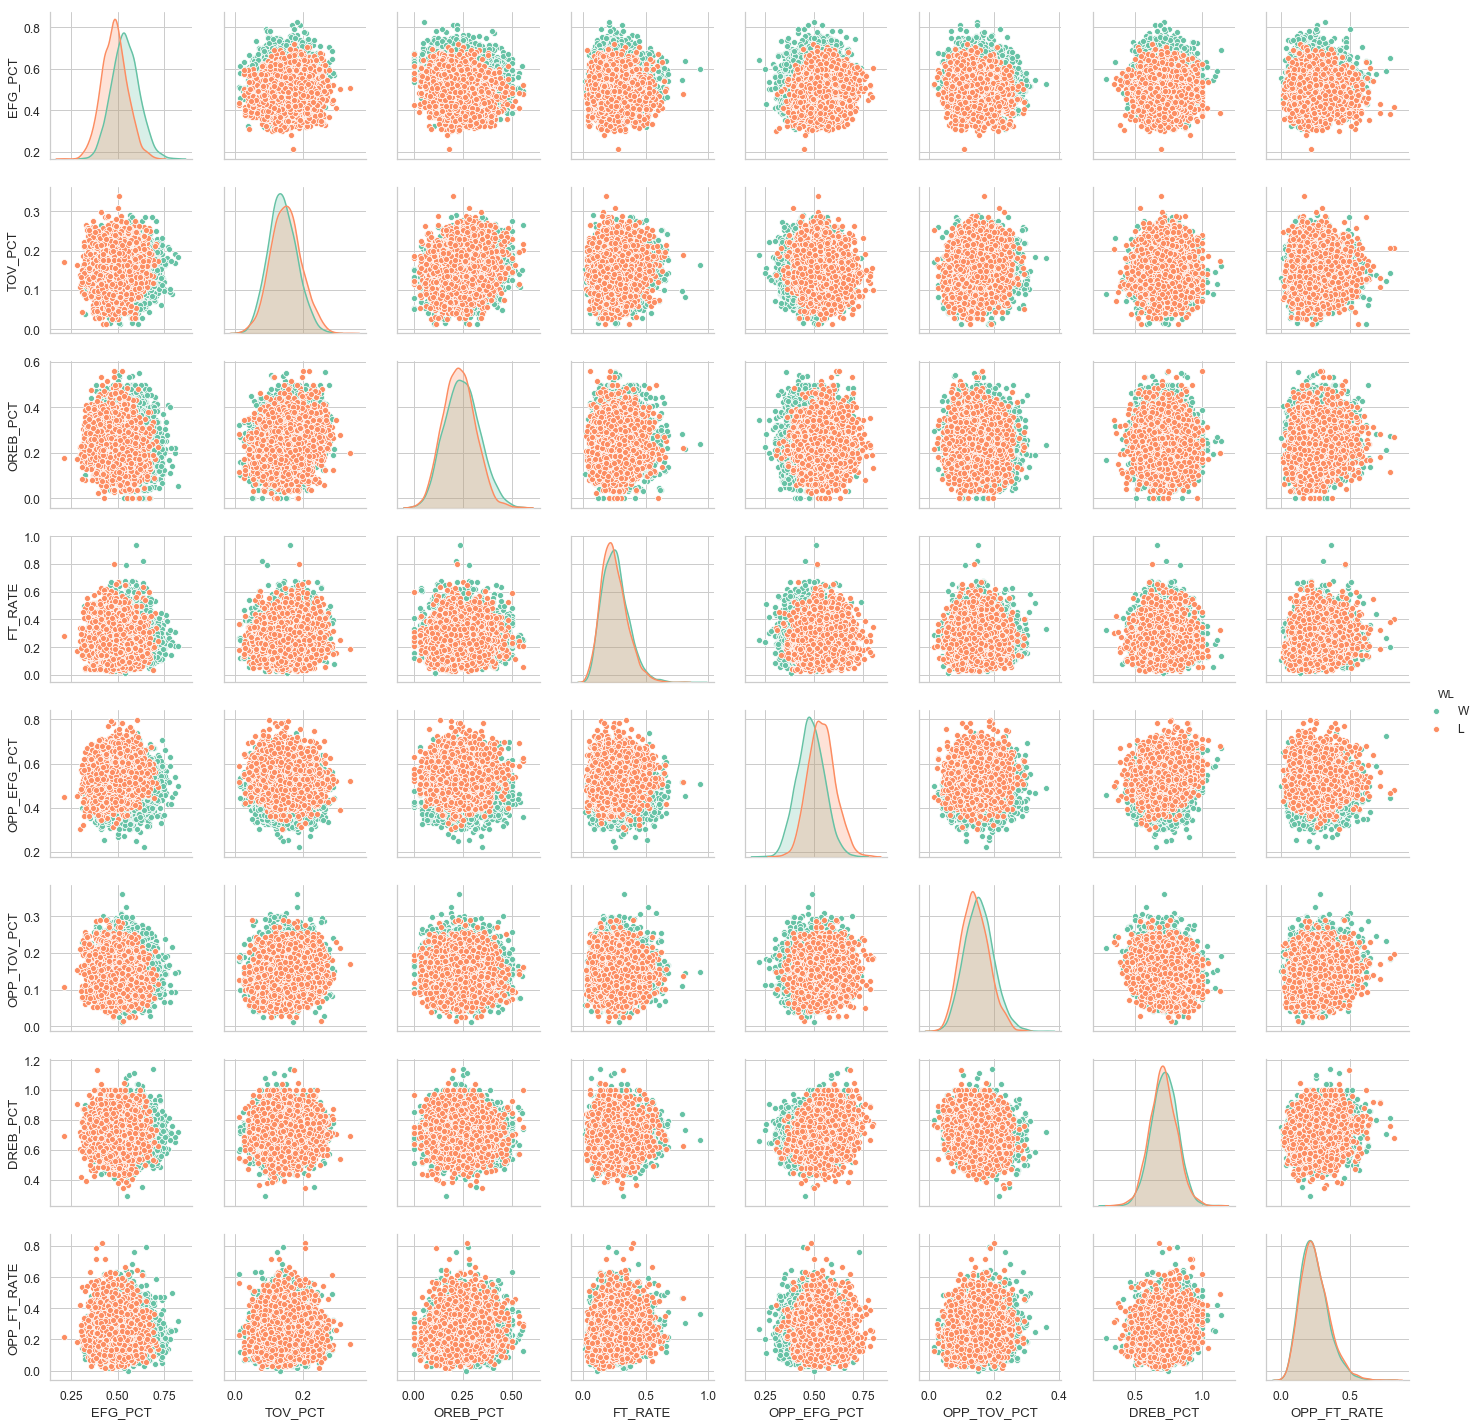

In [8]:
four_factor_feats = ['WL', 
                     'EFG_PCT', 'TOV_PCT', 'OREB_PCT', 'FT_RATE',
                     'OPP_EFG_PCT', 'OPP_TOV_PCT', 'DREB_PCT', 'OPP_FT_RATE']    

eda_pair_df = eda_df[four_factor_feats]
fig = plt.figure(figsize=(16,8))
sns.pairplot(eda_pair_df, kind='scatter', hue='WL', palette="Set2")

#### Pairplot Review

Looking across the diagonal, we can see a greater separation for W/L in Effective Field Goal % and Opponent Effective Field Goal %.  Likewise, looking across the top row, we can see how Effective Field Goal %, when compared with other features, show's a greater distinction between W/L than other categories.

Let's take another look, but only using Field Goal statistics and Turnover statistics.

<Figure size 1152x576 with 0 Axes>

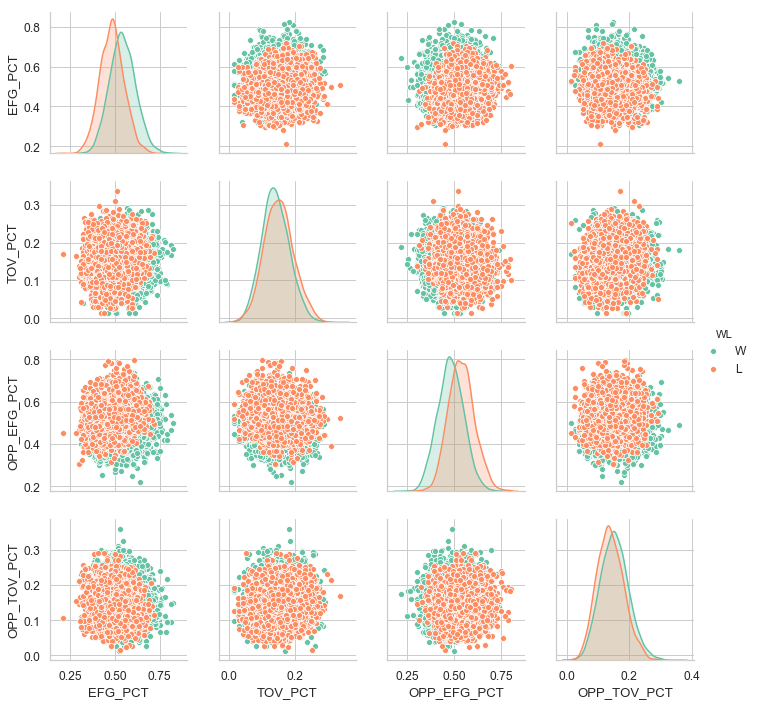

In [9]:
four_factor_feats_2 = ['WL', 'EFG_PCT', 'TOV_PCT', 'OPP_EFG_PCT', 'OPP_TOV_PCT']    

eda_pair_df = eda_df[four_factor_feats_2]
fig = plt.figure(figsize=(16,8))
sns.pairplot(eda_pair_df, kind='scatter', hue='WL', palette="Set2")

### Swarm Plot

#### Helper Function

In [10]:
def quantitative_summarized(dataframe, x=None, y=None, hue=None, palette='Set1', ax=None, verbose=True, swarm=False):
    '''
    Helper function that gives a quick summary of quantattive data
    Arguments
    =========
    dataframe: pandas dataframe
    x: str. horizontal axis to plot the labels of categorical data (usually the target variable)
    y: str. vertical axis to plot the quantitative data
    hue: str. if you want to compare it another categorical variable (usually the target variable if x is another variable)
    palette: array-like. Colour of the plot
    swarm: if swarm is set to True, a swarm plot would be overlayed
    Returns
    =======
    Quick Stats of the data and also the box plot of the distribution
    '''
    series = dataframe[x]
    print(series.describe())
    print('mode: ', series.mode())
    if verbose:
        print('='*80)
        print(series.value_counts())

    sns.boxplot(x=x, y=y, hue=hue, data=dataframe, palette=palette, ax=ax)

    if swarm:
        sns.swarmplot(x=x, y=y, hue=hue, data=dataframe,
                      palette=palette, ax=ax)

    plt.show()

#### Interactive Plot

In [11]:
feature_names = ['AST', 'BLK', 'PLUS_MINUS', 'OPP_AST', 'OPP_BLK',
                 'EFG_PCT', 'TOV_PCT', 'OREB_PCT', 'FT_RATE',
                 'OPP_EFG_PCT', 'OPP_TOV_PCT', 'DREB_PCT', 'OPP_FT_RATE']

@interact
def swarm_preview(feature = feature_names):
    sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [16, 6]})
    quantitative_summarized(dataframe= eda_df, y = 'WL', x = feature, palette="Set2", verbose=False, swarm=True)

interactive(children=(Dropdown(description='feature', options=('AST', 'BLK', 'PLUS_MINUS', 'OPP_AST', 'OPP_BLK…

### Annotated Heat Map

Here, let's take a look at the correlation heat map for our feature variables -- If there are correlations ~ 0.7, we may need to consider removing heavily correlated features.

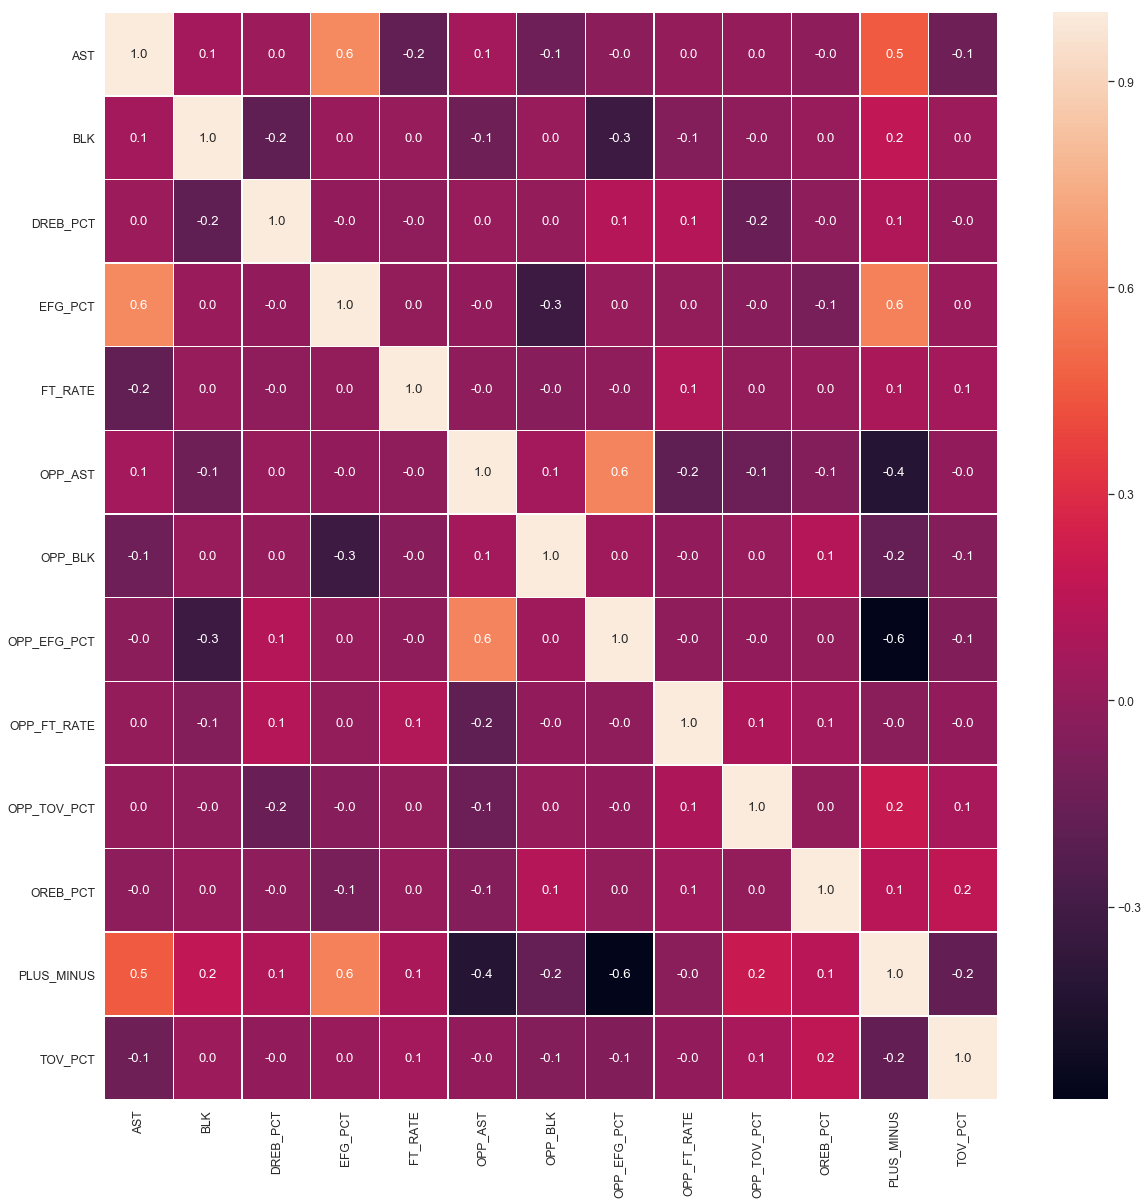

In [16]:
f,ax=plt.subplots(figsize=(20,20))
sns.heatmap(eda_df.corr(),annot=True,linewidth=.5,fmt='.1f',ax=ax)
plt.show()

#### Heat Map Takeaway

Very few of the remaining features show correlation, with the highest being 0.6/-0.6 between FG% and AST - which makes sense, as an AST is only possible if a FG is made.  Given that the correlations are all below 0.7, it does not look like we need to remove any features at the moment.

### Interactive Pie Charts

In [12]:
def f(min_value, max_value, columnn):
    games_won = eda_df.loc[(eda_df['WL'] == 'W') & (eda_df[columnn] >= min_value) & (eda_df[columnn] <= max_value)]
    games_lost = eda_df.loc[(eda_df['WL'] == 'L') & (eda_df[columnn] >= min_value) & (eda_df[columnn] <= max_value)]
    games_won_all = len(eda_df.loc[(eda_df['WL'] == 'W')])
    
    g_won_total = len(games_won)
    g_lost_total = len(games_lost)
    g_total = g_won_total + g_lost_total
    
    percent_won = round(g_won_total/g_total, 3)*100
    percent_lost = round(g_lost_total/g_total, 3)*100
    
    print("Of the total {} games \n".format(len(eda_df)))
    print("{} games had the stat >= {} and <= {}: \n".format(g_total, min_value, max_value))
    print("{} of {} games ({}%) resulted in a win \n".format(g_won_total, g_total, percent_won))
    print("{} of {} games ({}%) resulted in a loss \n".format(g_lost_total, g_total, percent_lost))
    
    # pie chart 1
    stat_array = [g_won_total, g_lost_total]
    labels = ["Won", "Lost"]
    
    # pie chart 2 
    won_array = [g_won_total, (games_won_all - g_won_total)]
    labels2 = ["Won w/ Stat Condition", "Won w/o Stat Condition"]
    
    colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
    
    # pie chart 1
    fig = plt.figure(figsize=(12,12))
    plt.subplot(1,2,1)
    plt.pie(stat_array, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.title("Win vs Loss Given Stat Condition")
    
    # pie chart 2
    plt.subplot(1,2,2)
    plt.pie(won_array, colors = colors, labels=labels2, autopct='%1.1f%%', startangle=90)
    plt.title("% of Wins w/ Stat")
    plt.show()

    return min_value

In [13]:
pcts = ['EFG_PCT', 'TOV_PCT', 'OREB_PCT', 'FT_RATE', 'OPP_EFG_PCT', 'OPP_TOV_PCT', 'OPP_FT_RATE', 'DREB_PCT']
interact(f, min_value=(0.0, 1.0, 0.01), max_value=(0.0, 1.0, 0.01), columnn=pcts)

interactive(children=(FloatSlider(value=0.5, description='min_value', max=1.0, step=0.01), FloatSlider(value=0…

<function __main__.f(min_value, max_value, columnn)>

# Pre-Modeling: Feature Scaling & Labeling

### Import Libraries

In [15]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

np.random.seed(0)

### Scale Feature Variables

In [16]:
model_df = final_df.copy()

# set features
X = model_df.drop('WL', axis=1)

# scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


### Label Encoding Target

In [17]:
# set target
y = model_df['WL']

# label encode target
le = LabelEncoder()
y = le.fit_transform(y)

# Modeling

## Decision Tree Classifier (Vanilla)

#### Import Necessary Libraries

In [18]:
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict, KFold, validation_curve

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, roc_curve, auc

# import pydotplus

#### Train Test Split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y, test_size=0.25, random_state=10)

#### Train Classifier & Make Predictions

In [20]:
classifier = DecisionTreeClassifier(random_state=10)  
classifier.fit(X_train, y_train)  

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=10,
            splitter='best')

In [21]:
# Make predictions for test data
y_pred = classifier.predict(X_test)  

### Check Predictive Performance

#### Confusion Matrix Function

In [22]:
def plot_confusion_matrix(y_test, y_pred):
    
    # Calculate Accuracy 
    acc = round(accuracy_score(y_test,y_pred) * 100,2)
    print("Accuracy is : {0}%".format(acc))

    # Check the AUC for predictions
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print("\nAUC is :{0}".format(round(roc_auc,2)))
    
    # normalized to %
    c_matrix_norm = confusion_matrix(y_test, y_pred)
    c_matrix_norm = c_matrix_norm.astype('float') / c_matrix_norm.sum(axis=1)[:, np.newaxis]
    
    # totals
    c_matrix_total = confusion_matrix(y_test, y_pred)

    classes = ["Loss", "Win"]
    
    f, ax = plt.subplots(1, 2, figsize=(16, 6))
    
    # Confusion Matrix Plot (Normalized)
    ax[0].set_title("Normalized Confusion Matrix", fontsize=18)
    sns.heatmap(pd.DataFrame(c_matrix_norm, index=classes, columns=classes), 
                cmap='Blues', annot=True, fmt='.2f', 
                annot_kws={"size": 20}, ax=ax[0]).set(xlabel="Predicted", ylabel="Actual")
    
    # Confusion Matrix Plot (Totals)
    ax[1].set_title("Confusion Matrix", fontsize=18)
    sns.heatmap(pd.DataFrame(c_matrix_total, index=classes, columns=classes), 
                cmap='Blues', annot=True, fmt='.0f', 
                annot_kws={"size": 20}, ax=ax[1]).set(xlabel="Predicted", ylabel="Actual")
    plt.show()

#### Confusion Matrix

Accuracy is :75.92936802973978

AUC is :0.75


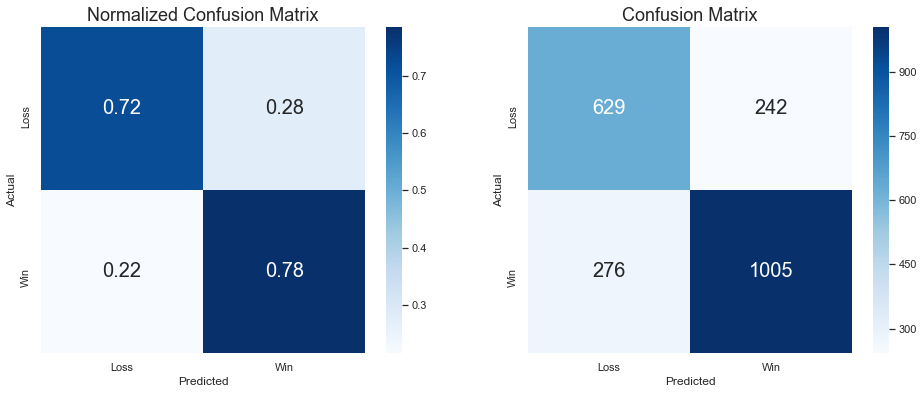

In [72]:
plot_confusion_matrix(y_test, y_pred)

#### Model Review

The out-of-the-box decision tree classifier had a 75% accuracy score, correctly predicting W/L for 1,634 of the 2,152 games.  The model has 276 false negative (predicted loss, but team won) and 242 false positives (predicted win, but team lost).  

From here, I'll use train another model using grid search to tune hyperparameters to see if the model can be significantly improved.

## Model Pipelines & Principal Component Analysis

#### Import Necessary Libraries

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

### Principal Components & Explained Variance

Here, we'll iterate over a range of possible principal components to see what our explained variance is at each number of components.  We want to reduce the dimensionality of our data, so if we can reduce the number of components needed while maintaining a high percentage of explained variance, we'll be better off when modeling. 

In [24]:
def principal_component_and_explained_variance(n_components, X):
    pca = PCA(n_components=n_components)
    principalComponents = pca.fit_transform(X)
    explained_var = round(np.sum(pca.explained_variance_ratio_)*100, 2)
    print("PCA with {} components has explained variance ratio of {}%".format(n_components, explained_var))
    
for i in range(1,11):
    principal_component_and_explained_variance(i, X)

PCA with 1 components has explained variance ratio of 81.99%
PCA with 2 components has explained variance ratio of 91.23%
PCA with 3 components has explained variance ratio of 95.84%
PCA with 4 components has explained variance ratio of 98.07%
PCA with 5 components has explained variance ratio of 99.98%
PCA with 6 components has explained variance ratio of 99.98%
PCA with 7 components has explained variance ratio of 99.99%
PCA with 8 components has explained variance ratio of 99.99%
PCA with 9 components has explained variance ratio of 100.0%
PCA with 10 components has explained variance ratio of 100.0%


Looks like the explained variance ratio is pretty high at multiple component levels, so we'll settle with 2 components, which explained 91% of the variance in our data.

#### Explained Variance Ratio (2 Principal Components)

In [25]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
print(pca.explained_variance_ratio_)

[0.81987011 0.09246409]


## SVM, Decision Tree, & Random Forest Classifier Pipelines

Before applying grid search to tune hyperparameters, I'll first create a pipeline for SVM, Decision Tree, & Random Forest to see which of the models performs the best, and which model to apply grid search (if not all).

#### Pipeline & Testing Accuracy

In [26]:
pipe_svm = Pipeline([('pca', PCA(n_components=2)),
                    ('clf', svm.SVC(random_state=10))])

pipe_tree = Pipeline([('pca', PCA(n_components=2)),
                     ('clf', tree.DecisionTreeClassifier(random_state=10))])

pipe_rf = Pipeline([('pca', PCA(n_components=2)),
                   ('clf', RandomForestClassifier(random_state=10))])

pipelines = [pipe_svm, pipe_tree, pipe_rf]

pipeline_names = ['SVM', 'Decision Tree', 'Random Forest']

for pipe in pipelines:
    print(pipe)
    print("*_*_*_*_*_")
    pipe.fit(X_train, y_train)
    
# Compare accuracies
for index, val in enumerate(pipelines):
    print('%s pipeline test accuracy: %.3f' % (pipeline_names[index], val.score(X_test, y_test)))

Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=10,
  shrinking=True, tol=0.001, verbose=False))])
*_*_*_*_*_


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=10,
            splitter='best'))])
*_*_*_*_*_
Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            ...rs='warn', n_jobs=None,
            oob_score=False, random_state=10, verbose=0, warm_start=False))])
*_*_*_*_*_


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


SVM pipeline test accuracy: 0.783
Decision Tree pipeline test accuracy: 0.680
Random Forest pipeline test accuracy: 0.728


#### Pipeline Review

SVM had the best score of the three models, having a testing accuracy of 78%.  The other two models were not very far off, so when applying grid search, I'll look at both SVM and Random Forest.

### Cross Validation & Visualize Classifier Accuracy

#### Split dataset into folds for cross validation

In [27]:
# Split data into 6 equal groups for validation
kfold = KFold(n_splits=6, shuffle=True, random_state=123)

#### Set Models

In [28]:
# Let's build different models to train with our data
validation_models = [RandomForestClassifier(n_estimators=200, random_state=123), 
          DecisionTreeClassifier(random_state=123), 
          svm.SVC(kernel='rbf', gamma='scale', random_state=123)]

#### Calculate Cross Validation Scores

In [29]:
mean, std = [], []
for m in validation_models:
    res = cross_val_score(m, X, y, cv=kfold, scoring="accuracy", n_jobs=-1)
    mean.append(res)
    std.append(res)

#### Plot Classifier Accuracy Scores

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


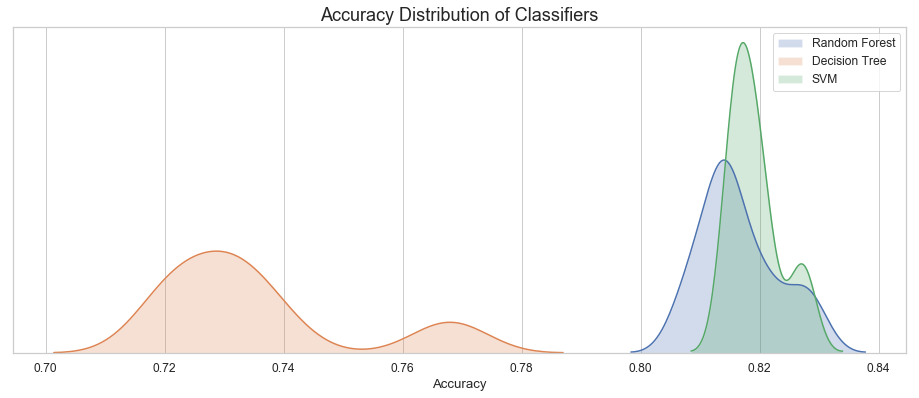

In [30]:
classifiers = ['Random Forest', 'Decision Tree', 'SVM']

plt.figure(figsize=(16, 6))
for i in range(len(mean)):
    sns.distplot(mean[i], hist=False, kde_kws={"shade": True})
    
plt.title("Accuracy Distribution of Classifiers", fontsize=18)
plt.legend(classifiers)
plt.xlabel("Accuracy")
plt.yticks([])

plt.show()

#### Cross Validation Review

Of the three models, Decision Tree was noticeably the worst performing model.  Random Forest & SVM had similar mean accuracy scores, with SVM having a slightly higher accuracy and more consistent results (lower standard deviation).  Next, I'll want to use grid search to find the optimal hyperparameters for Random Forest & SVM.

## SVM Grid Search Pipeline

#### Create Pipeline & Fit

In [31]:
pipe_svm = Pipeline([('pca', PCA(n_components=2)),
            ('clf', svm.SVC(random_state=123))])

# Set grid search params
param_grid_svm = [
  {'clf__C': [0.1, 1, 10], 
   'clf__kernel': ['linear']
  },
  {'clf__C': [1, 10], 
   'clf__gamma': [0.001, 0.01], 
   'clf__kernel': ['rbf']
  },
]

# Construct grid search
gs_svm = GridSearchCV(estimator=pipe_svm,
            param_grid=param_grid_svm,
            scoring='accuracy',
            cv=3, verbose=2, return_train_score = True)

# Fit using grid search
gs_svm.fit(X_train, y_train)

# Best accuracy
print('Best accuracy: %.3f' % gs_svm.best_score_)

# Best params
print('\nBest params:\n', gs_svm.best_params_)

Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] clf__C=0.1, clf__kernel=linear ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................... clf__C=0.1, clf__kernel=linear, total=   0.3s
[CV] clf__C=0.1, clf__kernel=linear ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] ................... clf__C=0.1, clf__kernel=linear, total=   0.3s
[CV] clf__C=0.1, clf__kernel=linear ..................................
[CV] ................... clf__C=0.1, clf__kernel=linear, total=   0.2s
[CV] clf__C=1, clf__kernel=linear ....................................
[CV] ..................... clf__C=1, clf__kernel=linear, total=   0.2s
[CV] clf__C=1, clf__kernel=linear ....................................
[CV] ..................... clf__C=1, clf__kernel=linear, total=   0.2s
[CV] clf__C=1, clf__kernel=linear ....................................
[CV] ..................... clf__C=1, clf__kernel=linear, total=   0.3s
[CV] clf__C=10, clf__kernel=linear ...................................
[CV] .................... clf__C=10, clf__kernel=linear, total=   0.3s
[CV] clf__C=10, clf__kernel=linear ...................................
[CV] .................... clf__C=10, clf__kernel=linear, total=   0.2s
[CV] clf__C=10, clf__kernel=linear ...................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:   11.6s finished


Best accuracy: 0.772

Best params:
 {'clf__C': 10, 'clf__gamma': 0.01, 'clf__kernel': 'rbf'}


#### SVM Grid Search Pipeline Review

The best performing SVM model had an accuracy of 81% and the following values for hyperparameters:

**C**: 10

**kernel**: rbf

**gamma**: 0.01

#### Run SVM with Optimal Hyperparameters

In [32]:
regressor = svm.SVC(random_state=123,
                    C=10,
                    gamma=0.01,
                    kernel='rbf'
                   )


regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

#### Review Model Performance

              precision    recall  f1-score   support

           0       0.80      0.75      0.77       871
           1       0.84      0.87      0.85      1281

   micro avg       0.82      0.82      0.82      2152
   macro avg       0.82      0.81      0.81      2152
weighted avg       0.82      0.82      0.82      2152

Accuracy is : 82.3%

AUC is :0.81


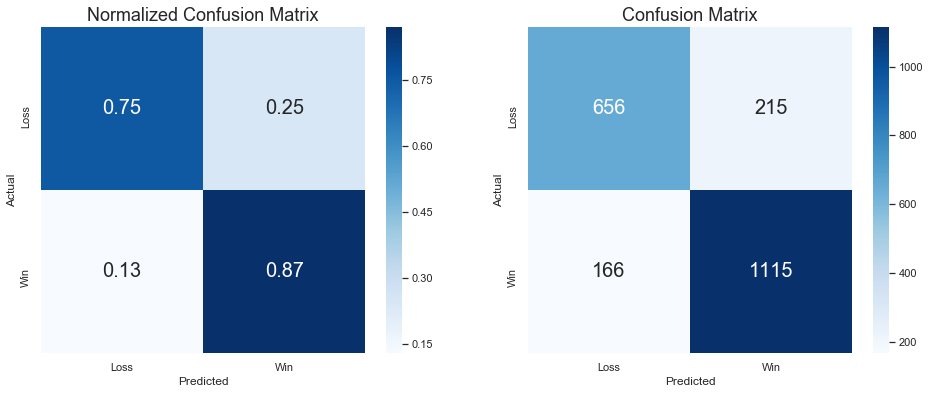

In [115]:
# classification report
print(classification_report(y_test, y_pred))

# confusion matrix
plot_confusion_matrix(y_test, y_pred)

The SVM with optimal hyperparameters did much better than the previous model.  The accuracy jumped up to 82.3% and the False Negative rate (predicting a loss, when team actually won) dropped significantly from 0.22 to 0.13.

### Accuracy Review

**Precision** = True Positive / (True Positive + False Positive)

Or, Total True Positive / Total Predicted Positive.  Precision is preferred when the cost of a False Positive is high, such as spam.  A wrongly classified work email that hits your spam folder is worse than an errant spam email making it into your inbox.

**Recall** = True Positive / (True Positive + False Negative)

Or, True Positive / Total Actual Positive.  Recall measures the accuracy of how many of the actual positives the model labels as positive.  Recall is preferred when the cost of a False Negative is high, such as when diagnosing medical conditions.

**F1 Score** = 2 * (Precision * Recall)/(Precision + Recall)

#### Which Accuracy Score Is Best?

Unfortunately, as the architect of this problem/question, I don't find reason to favor one metric to another.  In other scenarios, each can be incredibly important, but here, I'm solely trying to correctly determine if a game was won or lost.  That being said, one is looking for, **ideally**, a false positive rate of zero and a true positive rate of one.  While unrealistic, this means to focus on increasing the area under the curve (AUC) when comparing true positive rate and false positive rate.

## Random Forest Grid Search Pipeline

#### Create Pipeline & Fit

In [116]:
# Construct pipeline
pipe_rf = Pipeline([('pca', PCA(n_components=2)),
            ('clf', RandomForestClassifier(random_state = 123))])

# Set grid search params
param_grid_forest = [ 
  {'clf__n_estimators': [120],
   'clf__criterion': ['entropy', 'gini'], 
   'clf__max_depth': [4, 5, 6],  
   'clf__min_samples_leaf':[0.02, 0.05 ,0.1, 0.2],  
   'clf__min_samples_split':[0.02, 0.05 ,0.1, 0.2]
  }
]

# Construct grid search
gs_rf = GridSearchCV(estimator=pipe_rf,
            param_grid=param_grid_forest,
            scoring='accuracy',
            cv=3, verbose=2, return_train_score = True)

# Fit using grid search
gs_rf.fit(X_train, y_train)

# Best accuracy
print('Best accuracy: %.3f' % gs_rf.best_score_)

# Best params
print('\nBest params:\n', gs_rf.best_params_)

Fitting 3 folds for each of 96 candidates, totalling 288 fits
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.02, clf__min_samples_split=0.02, clf__n_estimators=120 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.02, clf__min_samples_split=0.02, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.02, clf__min_samples_split=0.02, clf__n_estimators=120 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.02, clf__min_samples_split=0.02, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.02, clf__min_samples_split=0.02, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.02, clf__min_samples_split=0.02, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.02, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.02, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.02, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.02, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf_

[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_l

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__m

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.02, clf__min_samples_split=0.02, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.02, clf__min_samples_split=0.02, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.02, clf__min_samples_split=0.02, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.02, clf__min_samples_split=0.02, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_s

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_

[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.02, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.02, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.02, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, 

[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.02, clf__min_samples_split=0.02, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.02, clf__min_samples_split=0.02, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.02, clf__min_samples_split=0.02, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.02, clf__min_samples_split=0.02, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.02, clf__m

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_sample

[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.02, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, 

[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s


[Parallel(n_jobs=1)]: Done 288 out of 288 | elapsed:  1.3min finished


Best accuracy: 0.772

Best params:
 {'clf__criterion': 'gini', 'clf__max_depth': 5, 'clf__min_samples_leaf': 0.02, 'clf__min_samples_split': 0.02, 'clf__n_estimators': 120}


#### Random Forest Grid Search Pipeline Review

The best performing Random Forest had an accuracy of 77.2% and the following values for hyperparameters:

**criterion**: gini

**max_depth**: 4

**min_samples_leaf**: 0.05

**min_samples_split**: 0.2

**n_estimators**: 120

#### Validation Curve - Visualize Hyperparameter Tuning

Here, I'll quickly plot the accuracy score for the training and test sets with different values for the hyperparameters above.  Grid search already selected what the best values were, but this is a sanity check.

In [33]:
param_options = ["max_depth", "min_samples_leaf", "min_samples_split", "n_estimators"]
@interact

def plot_validation_curve(param = param_options):
    param_ranges = {
        "max_depth": [3,4,5,6,7],
        "min_samples_leaf": np.linspace(.01, 0.3, 40),
        "min_samples_split": np.linspace(.01, 0.2, 40),
        "n_estimators": np.arange(10,150,10)
    }
    
    param_range = param_ranges[param]

    # Calculate accuracy on training and test
    train_accuracy, test_accuracy = validation_curve(RandomForestClassifier(), 
                                                 X, 
                                                 y, 
                                                 param_name=param, 
                                                 param_range=param_range,
                                                 cv=3, 
                                                 scoring="accuracy", 
                                                 n_jobs=-1)


    # train mean and standard deviation
    train_mean = np.mean(train_accuracy, axis=1)
    train_std = np.std(train_accuracy, axis=1)

    # test mean and standard deviation
    test_mean = np.mean(test_accuracy, axis=1)
    test_std = np.std(test_accuracy, axis=1)

    fig = plt.figure(figsize=(12,6))
    
    # Plot train/test mean accuracy scores
    plt.plot(param_range, train_mean, label="Training score", color="red")
    plt.plot(param_range, test_mean, label="Cross validation score", color="dimgrey")

    # Plot train/test accurancy bands
    plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
    plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

    plt.title("Validation Curve")
    plt.xlabel(param)
    plt.ylabel("Accuracy Score")
    plt.tight_layout()
    plt.legend(loc="best")
    plt.show()


interactive(children=(Dropdown(description='param', options=('max_depth', 'min_samples_leaf', 'min_samples_spl…

#### Run Random Forest with Optimal Hyperparameters

              precision    recall  f1-score   support

           0       0.80      0.75      0.77       871
           1       0.84      0.87      0.85      1281

   micro avg       0.82      0.82      0.82      2152
   macro avg       0.82      0.81      0.81      2152
weighted avg       0.82      0.82      0.82      2152

Accuracy is : 82.11%

AUC is :0.81


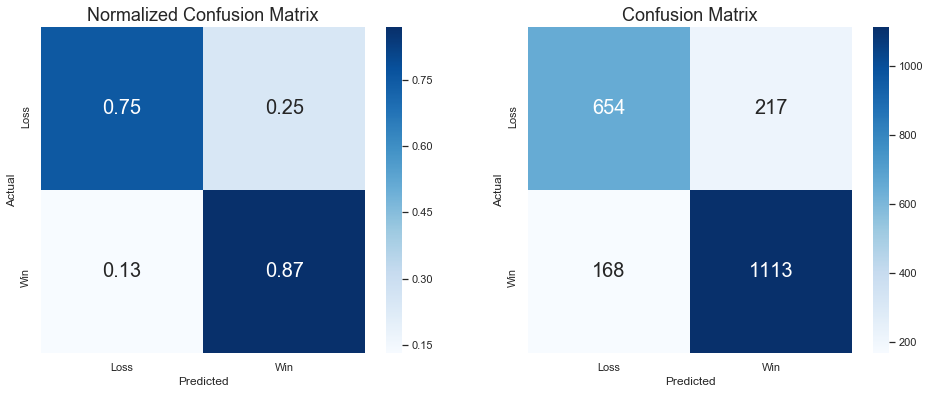

In [122]:
regressor = RandomForestClassifier(random_state=123,
                                   min_samples_split=0.2,
                                   min_samples_leaf=0.05,
                                   max_depth=4,
                                   criterion='gini',
                                   n_estimators=120)


regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

# classification report
print(classification_report(y_test, y_pred))

# confusion matrix
plot_confusion_matrix(y_test, y_pred)

#### Random Forest Model Review

The Random Forest Classifier ended up doing much better after tuning, ending with an accuracy of 82%, and improved False Positive rate.  

#### Checking Feature Importance

In [123]:
feats = model_df.drop('WL', axis=1)
feature_importance = pd.Series(regressor.feature_importances_,index=feats.columns).sort_values(ascending=False)
feature_importance

PLUS_MINUS     0.504466
EFG_PCT        0.176280
OPP_EFG_PCT    0.155330
AST            0.065545
OPP_AST        0.055085
OPP_TOV_PCT    0.020199
TOV_PCT        0.008144
OREB_PCT       0.006655
BLK            0.005790
DREB_PCT       0.001232
OPP_BLK        0.000843
FT_RATE        0.000431
OPP_FT_RATE    0.000000
dtype: float64

As expected, PLUS_MINUS (the current difference in score at the end of the third quarter) has the highest value (0.50), and it is significantly greater than the other features.  Following PLUS_MINUS, the most important features are shooting percentages (Home 0.176, Opponent 0.155), followed by assists (Home 0.06, Opponent 0.055).

#### Visualizing Feature Importance

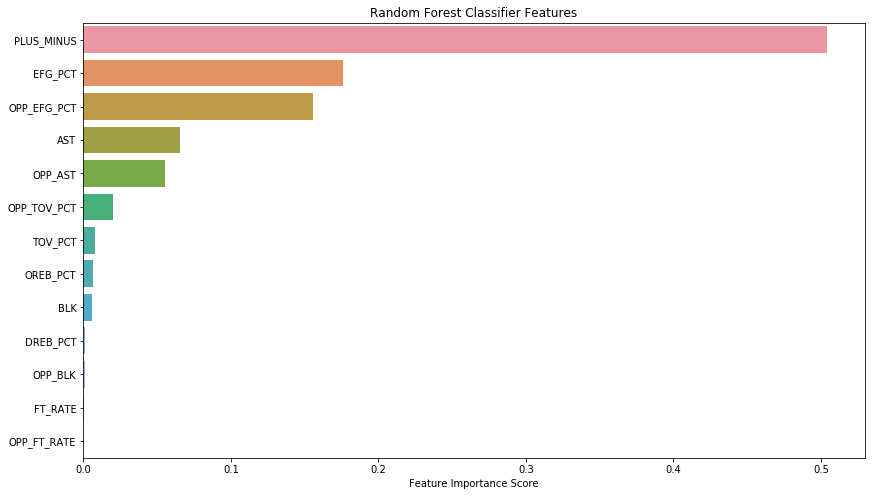

In [102]:
# Create bar plot
fig = plt.figure(figsize=(14,8))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.xlabel('Feature Importance Score')
# plt.ylabel('Features')
plt.title("Random Forest Classifier Features")
plt.show()

#### Random Forest Classifier With Only Top Features

From the feature importance bar chart, it looks like Opponent Free Throw Rate (OPP_FT_RATE), Free Throw Rate (FT_RATE), Opponent Blocks (OPP_BLK), & Defensive Rebound Percent (DREB_PCT) are rather unimportant.  Let's re-run the random forest classifier with only the top 9 features to see if this model performs better.

#### Set Reduced Feature Variables

In [124]:
# set features
X_fin = model_df.drop(['WL', 'OPP_FT_RATE', 'FT_RATE', 'OPP_BLK', 'DREB_PCT', 'BLK'], axis=1)

# scale features
scaler = MinMaxScaler()
X_fin_scaled = scaler.fit_transform(X_fin)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


#### Train Test Split

In [125]:
X_train_fin, X_test_fin, y_train_fin, y_test_fin = train_test_split(X_fin_scaled,y, test_size=0.25, random_state=10)

#### Fit Random Forest Classifier & Predict

              precision    recall  f1-score   support

           0       0.80      0.75      0.77       871
           1       0.84      0.87      0.85      1281

   micro avg       0.82      0.82      0.82      2152
   macro avg       0.82      0.81      0.81      2152
weighted avg       0.82      0.82      0.82      2152

Accuracy is : 82.2%

AUC is :0.81


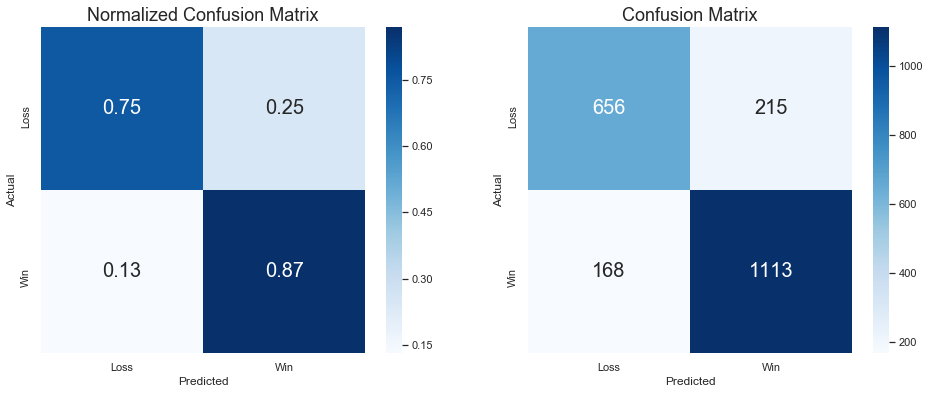

In [126]:
regressor = RandomForestClassifier(random_state=123,
                                   min_samples_split=0.2,
                                   min_samples_leaf=0.05,
                                   max_depth=4,
                                   criterion='gini',
                                   n_estimators=120)

regressor.fit(X_train_fin, y_train_fin)
y_pred_fin = regressor.predict(X_test_fin)

# classification report
print(classification_report(y_test_fin, y_pred_fin))

# confusion matrix
plot_confusion_matrix(y_test_fin, y_pred_fin)

#### Model Review

Using only the top 9 features, we ended up with slightly better accuracy score of 82.2% (up about a percent).  Having fewer features is, generally, better, so this is probably the best we're going to do.

# Conclusion

### Model Comparison

<table>
    <thead>
        <tr>
            <th>Model</th>
            <th>Accuracy</th>
            <th>TP</th>
            <th>TN</th>
            <th>FP</th>
            <th>FN</th>
            <th>Parameters</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>SVM</td>
            <td>82.3%</td>
            <td>0.87</td>
            <td>0.75</td>
            <td>0.25</td>
            <td>0.13</td>
            <td>C=10, gamma=0.01, kernel='rbf'</td>
        </tr>
        <tr>
            <td>Random Forest</td>
            <td>82.2%</td>
            <td>0.87</td>
            <td>0.75</td>
            <td>0.25</td>
            <td>0.13</td>
            <td>criterion: gini, max_depth: 4, min_samples_leaf: 0.05, min_samples_split: 0.2, n_estimators: 120</td>
        </tr>
    </tbody>
</table>

Both models, after hyperparameter tuning, ended up with ~82% accuracy scores, and almost identical false positive, true positive, false negative, true negative rates.  Given that the results are nearly identical, I would be fine working with either model going forward.

### Feature Importance

In the Random Forest classifier, the most important feature was PlUS_MINUS, followed by shooting statistics.  This is intuitive, since, if you're losing through three quarters (75% of the game), you have to have a 4th quarter that diverges from the losing trend set by the first three quarters.  And, in doing so, it doesn't necessarily equate into a win, just a closer game.

### Future Work

If I had more time, I would have liked to re-structure the initial question and try to predict ranges of game outcomes in terms of PLUS_MINUS.  That is, rather than predicting a win or a loss, I would focus on creating a model that could predict ranges of PLUS_MINUS (ex, <5 points is a "very close" game, 5 < x < 10 points is an "average" game, and > 10 points would be a clear win).  

Additionally, I would be interested in creating a model that either makes a prediction given a confidence level, or abstains from predicting.  That is, I would rather have the model reveal "Games in which the winner is X 95% of the time", rather than predicting games that are hard to classify.

# Presentation Visualizations

#### Feature Importance Bar Plot

Text(0.5, 0, 'Weight')

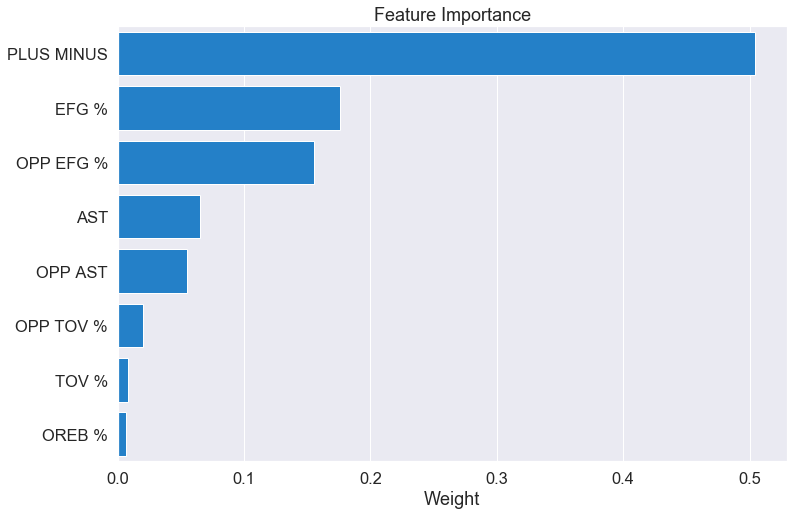

In [17]:
labels = ["PLUS MINUS", "EFG %", "OPP EFG %", "AST", "OPP AST", "OPP TOV %", "TOV %", "OREB %"]
values = [0.504466, 0.176280, 0.155330, 0.065545, 0.055085, 0.020199, 0.008144, 0.006655, ]
c = dict(zip(labels, values))

sns.set(font_scale=1.5)
fig = plt.figure(figsize=(12,8))
ax = sns.barplot(x=values, y=labels, color="#0984e3")
plt.title("Feature Importance")
plt.xlabel("Weight")

In [18]:
pres_df = eda_df.copy()
pres_df_w = pres_df.loc[pres_df["WL"] == "W"] # games that were won
pres_df_l = pres_df.loc[pres_df["WL"] == "L"] # games that were lost

feature_names = ['AST', 'BLK', 'PLUS_MINUS', 'OPP_AST', 'OPP_BLK',
                 'EFG_PCT', 'TOV_PCT', 'OREB_PCT', 'FT_RATE',
                 'OPP_EFG_PCT', 'OPP_TOV_PCT', 'DREB_PCT', 'OPP_FT_RATE']

cats = ['AST', 'EFG_PCT', 'TOV_PCT']
net_in_win = []
net_in_loss = []
net_all = []
for cat in cats:
    avg_win = np.mean(pres_df_w[cat])
    avg_opp_win = np.mean(pres_df_w['OPP_' + cat])
    diff = avg_win - avg_opp_win
    net_in_win.append(diff)
    net_all.append(diff)
    avg_loss = np.mean(pres_df_l[cat])
    avg_opp_loss = np.mean(pres_df_l['OPP_' + cat])
    diff2 = avg_loss - avg_opp_loss
    net_in_loss.append(diff2)

for v in net_in_loss:
    net_all.append(v)
    

In [23]:
net_in_win

[3.0373813291139236, 0.060371043332058894, -0.012854748612109251]

In [24]:
net_in_loss

[-2.0365990990990994, -0.05490539608305506, 0.01085970197803654]

Text(0.5, 0, 'Weight')

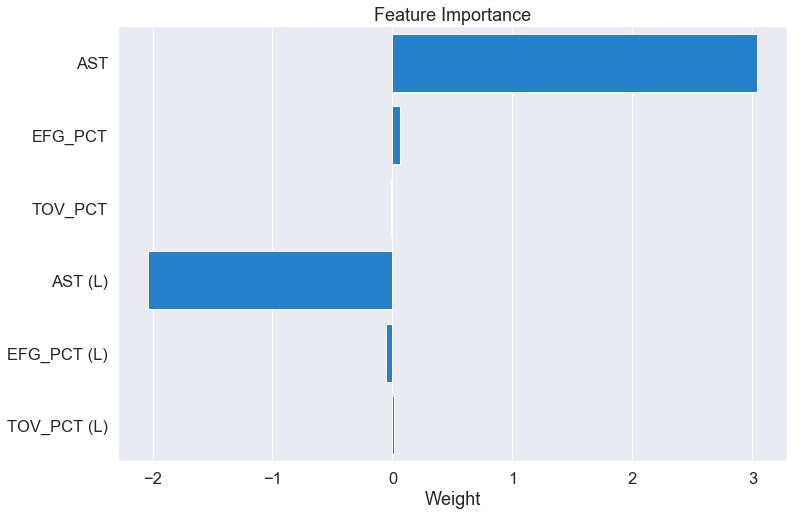

In [32]:
# cats2 = ['AST', 'EFG_PCT', 'TOV_PCT', 'AST (L)', 'EFG_PCT (L)', 'TOV_PCT (L)']
# sns.set(font_scale=1.5)
# fig = plt.figure(figsize=(12,8))
# ax = sns.barplot(x=net_all, y=cats2, color="#0984e3")
# plt.title("Feature Importance")
# plt.xlabel("Weight")

Text(0.5, 0, 'NET Effective Field Goal %')

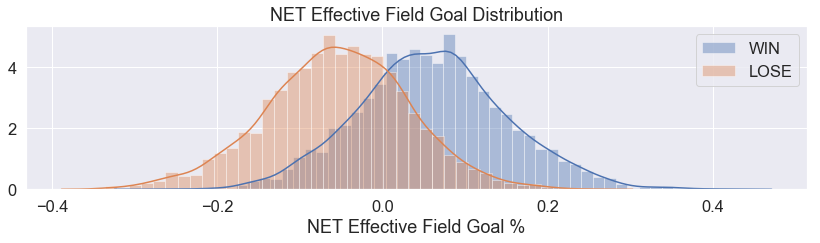

In [21]:
cats2 = ['AST', 'EFG_PCT', 'TOV_PCT', 'AST (L)', 'EFG_PCT (L)', 'TOV_PCT (L)']
cat = ['FG%']
val1 = net_in_win[1]
val2 = net_in_loss[1]
sns.set(font_scale=1.5)
fig = plt.figure(figsize=(14,3))
# ax = sns.barplot(x=val1, y=cat, color="#0984e3")
# ax = sns.barplot(x=val2, y=cat, color="#fc5c65")
# plt.title("Feature Importance")
# plt.xlabel("Weight")

net_fgs = pres_df_w['EFG_PCT'] - pres_df_w['OPP_EFG_PCT']
net_fgs_l = pres_df_l['EFG_PCT'] - pres_df_l['OPP_EFG_PCT']
sns.distplot(net_fgs, label="WIN")
sns.distplot(net_fgs_l, label="LOSE")
plt.legend()
plt.title("NET Effective Field Goal Distribution")
plt.xlabel("NET Effective Field Goal %")



Text(0.5, 0, 'Effective Field Goal %')

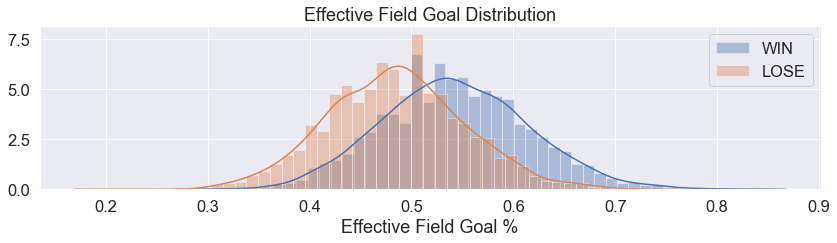

In [22]:
cats2 = ['AST', 'EFG_PCT', 'TOV_PCT', 'AST (L)', 'EFG_PCT (L)', 'TOV_PCT (L)']
cat = ['FG%']
val1 = net_in_win[1]
val2 = net_in_loss[1]
sns.set(font_scale=1.5)
fig = plt.figure(figsize=(14,3))
# ax = sns.barplot(x=val1, y=cat, color="#0984e3")
# ax = sns.barplot(x=val2, y=cat, color="#fc5c65")
# plt.title("Feature Importance")
# plt.xlabel("Weight")

net_fgs = pres_df_w['EFG_PCT']
net_fgs_l = pres_df_l['EFG_PCT']
sns.distplot(net_fgs, label="WIN")
sns.distplot(net_fgs_l, label="LOSE")
plt.legend()
plt.title("Effective Field Goal Distribution")
plt.xlabel("Effective Field Goal %")



Text(0.5, 0, 'Opponent Effective Field Goal %')

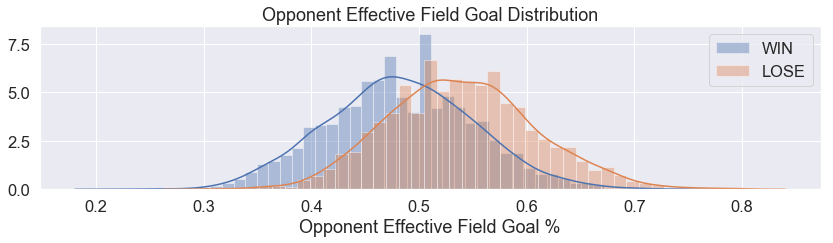

In [23]:
cats2 = ['AST', 'EFG_PCT', 'TOV_PCT', 'AST (L)', 'EFG_PCT (L)', 'TOV_PCT (L)']
cat = ['FG%']
val1 = net_in_win[1]
val2 = net_in_loss[1]
sns.set(font_scale=1.5)
fig = plt.figure(figsize=(14,3))
# ax = sns.barplot(x=val1, y=cat, color="#0984e3")
# ax = sns.barplot(x=val2, y=cat, color="#fc5c65")
# plt.title("Feature Importance")
# plt.xlabel("Weight")

net_fgs = pres_df_w['OPP_EFG_PCT']
net_fgs_l = pres_df_l['OPP_EFG_PCT']
sns.distplot(net_fgs, label="WIN")
sns.distplot(net_fgs_l, label="LOSE")
plt.legend()
plt.title("Opponent Effective Field Goal Distribution")
plt.xlabel("Opponent Effective Field Goal %")



In [52]:
plus_0w = pres_df.loc[(pres_df['PLUS_MINUS'] == 0) & (pres_df['WL'] == 'W')]
plus_0l = pres_df.loc[(pres_df['PLUS_MINUS'] == 0) & (pres_df['WL'] == 'L')]

plus_pw = pres_df.loc[(pres_df['PLUS_MINUS'] > 0) & (pres_df['WL'] == 'W')]
plus_pl = pres_df.loc[(pres_df['PLUS_MINUS'] > 0) & (pres_df['WL'] == 'L')]

plus_nw = pres_df.loc[(pres_df['PLUS_MINUS'] < 0) & (pres_df['WL'] == 'W')]
plus_nl = pres_df.loc[(pres_df['PLUS_MINUS'] < 0) & (pres_df['WL'] == 'L')]


labels = ["Win", "Loss"]
tied_wl_counts = [len(plus_0w), len(plus_0l)]
up_wl_counts = [len(plus_pw), len(plus_pl)]
down_wl_counts = [len(plus_nw), len(plus_nl)]


# plus_p = pres_df.loc[pres_df['PLUS_MINUS'] == 0]
print(len(plus_0w))
print(len(plus_0l))

171
122


Text(0.5, 1.0, 'Win vs. Loss (Tie Game)')

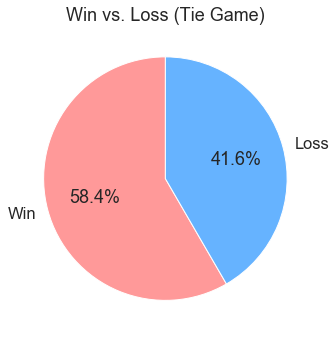

In [54]:
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
# PIE - WIN v LOSS (PLUS_MINUS == 0)
fig = plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.pie(tied_wl_counts, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("Win vs. Loss (Tie Game)")

Text(0.5, 1.0, 'Win vs. Loss (3rd Q Lead)')

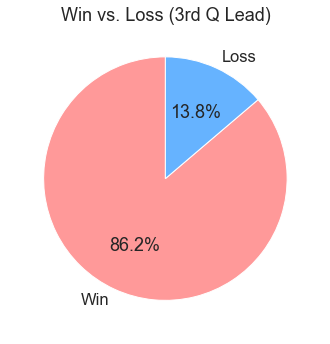

In [83]:
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
# PIE - WIN v LOSS (PLUS_MINUS > 0)
fig = plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.pie(up_wl_counts, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("Win vs. Loss (3rd Q Lead)")

Text(0.5, 1.0, 'Win vs. Loss (3rd Q Deficit)')

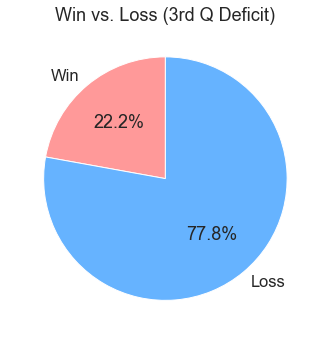

In [84]:
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
# PIE - WIN v LOSS (PLUS_MINUS < 0)
fig = plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.pie(down_wl_counts, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("Win vs. Loss (3rd Q Deficit)")

Text(0.5, 1.0, 'Win vs. Loss (5 PT GAME)')

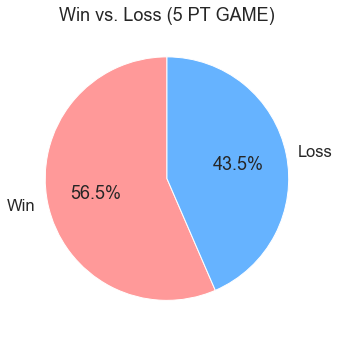

In [86]:
close_w = pres_df.loc[(pres_df['PLUS_MINUS'] >= -5) & (pres_df['PLUS_MINUS'] <= 5) & (pres_df['WL'] == 'W')]
close_l = pres_df.loc[(pres_df['PLUS_MINUS'] >= -5) & (pres_df['PLUS_MINUS'] <= 5) & (pres_df['WL'] == 'L')]
close_counts = [len(close_w), len(close_l)]
labels = ["Win", "Loss"]

colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
# PIE - WIN v LOSS (PLUS_MINUS < 0)
fig = plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.pie(close_counts, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("Win vs. Loss (5 PT GAME)")

Text(0.5, 1.0, 'Win vs. Loss (<10 PT GAME)')

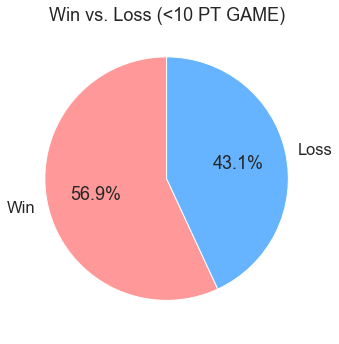

In [88]:
close_w = pres_df.loc[(pres_df['PLUS_MINUS'] >= -3) & (pres_df['PLUS_MINUS'] <= 3) & (pres_df['WL'] == 'W')]
close_l = pres_df.loc[(pres_df['PLUS_MINUS'] >= -3) & (pres_df['PLUS_MINUS'] <= 3) & (pres_df['WL'] == 'L')]
close_counts = [len(close_w), len(close_l)]
labels = ["Win", "Loss"]

colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
# PIE - WIN v LOSS (PLUS_MINUS < 0)
fig = plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.pie(close_counts, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("Win vs. Loss (<10 PT GAME)")

Text(0.5, 1.0, 'Win vs. Loss')

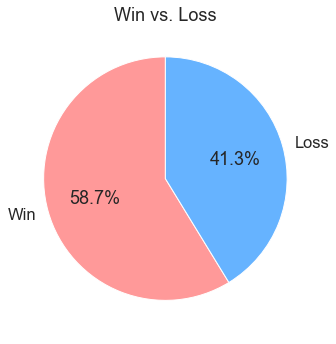

In [11]:
gw = pres_df.loc[(pres_df['WL'] == 'W')]
gl = pres_df.loc[(pres_df['WL'] == 'L')]
close_counts = [len(gw), len(gl)]
labels = ["Win", "Loss"]

colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
# PIE - WIN v LOSS (PLUS_MINUS < 0)
fig = plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.pie(close_counts, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("Win vs. Loss")